# ***QTM 350 Final Project***
### Olivia Song, Elizabeth Bryant, Betty Li, and Aaron Leonard, and Alexa Yanar
![Climate](https://www.noaa.gov/sites/default/files/styles/scale_crop_1120x534/public/thumbnails/image/Photo%20collage-climate%20scenarios-global%20climate%20reports-NOAA%20image-landscapes.jpg?itok=rcowMNf5)

For our Data Science Capstone, our group analyzed NOAA Global Historical Climatology Network Daily data from the Registry of Open Data on AWS (https://registry.opendata.aws/noaa-ghcn/). We found this dataset interesting because climate change has been a major topic in the news for the past few years. Also, weather data is faily easy to work with since all the variables are familiar. This dataset contains daily observations for precipitation, temperature, snow depth, and time of observation from multiple resources since 1763. We decided to focus on data from 2019 and 1919, since 2019 is the most current and complete and 1919 is exactly 100 years before. We can compare the data to see how climate has changed over the years. Our work can be found at https://github.com/miaowu128/QTM350FinalProject.git.

We began by looking at the documentation included on the Open Data Registry (https://docs.opendata.aws/noaa-ghcn-pds/readme.html). The readme file gave us insight on the variables we would be looking at. Dr. Jacobson also helped us research some other published notebooks that used the data to see if we could build off of previous work. These were great examples;however, the first notebook used a different file than the one we chose and the second was used to demonstrate how to use various python packages. 

### *Notebook Examples*
- https://livebook.manning.com/book/the-quick-python-book-third-edition/case-study/1
- https://www.kaggle.com/kerneler/starter-aws-open-source-weather-4e419ab3-9

# ***Themes and Extensions***
## **Alexa Yanar**
Themes can be a very good way to engage the reader further, by providing different colors and fonts to break up the seas of white in the default Jupyter Notebook theme. We'll be doing so by using Jupyter Themes, a program created by Kyle Donovan, whose Github can be found here: https://github.com/dunovank/jupyter-themes. This Github helps provide basic information about setting up Jupyter Themes, as well as trouble-shooting. To get started, we need to install jupyterthemes, and install and update packages that we need up to date.

In [ ]:
!pip install -U jupyter

In [ ]:
!pip install sparkmagic

In [ ]:
!pip install --upgrade notebook==6.0.2

In [ ]:
!pip install --upgrade sparkmagic==0.14.0

In [ ]:
!pip install --upgrade jupyter-core==4.6.0

In [ ]:
!pip install jupyterthemes

In [10]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


## **Font and Size**
Jupyterthemes allow for so much more than just changing the themes. It can also extend to fonts, font size, text, and more. Below you can see their whole command line options. For this notebook, we'll be experimenting with fonts for the different cells and their sizes. In this notebook, we'll be using the solarizedl theme, Source Code Pro for the code cell font, Source Sans for the notebook font, a notebook font of size 11, a text cell font of Crimson Serif, the text cell font size to 11, and the Output Area fontsize to 8.

In [11]:
!jt -t solarizedl -f sourcemed -nf sourcesans -nfs 11 -tf crimsonserif -tfs 11 -ofs 8

After inputting your preferences, you've made the biggest changes to the aesthetics! The reader will have plenty of visual interest, but what about readibility? Functionality? The last step we'll do is add notebook extensions to increase functionality on both ends--for the reader and creators.

## **Extensions**
Jupyter notebooks are great a great tool to use for a variety of reasons, especially considering it was made to have be an extendable environment. But what are extensions? They're simple tools usually coded in Javascript which can be added on to notebooks to increase their functionality. Some of the extensions that we'll be using include spellchecking and table of contents. First, we need to install and enable the extension manager, since its default is turned off.

In [ ]:
!pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master

In [ ]:
!jupyter contrib nbextension install --user

In [ ]:
!jupyter nbextension enable codefolding/main

In [ ]:
!jupyter nbextension enable spellchecker/main

In [ ]:
!jupyter nbextension enable table_beautifier/main

# ***Data Architecture***
Throughout this semester we have learned about many AWS services that can be useful for running big data. Some of the services we used for our project are: Registry of Open Data, s3, EC2 instance, and SageMaker. Using draw.io, we created a diagram to show our workflow.
![Data Architecture](QTM350_FinalProject.png)

# ***Cleaning & Analysis***

## **Elizabeth Bryant**

First, we started by accessing the data from the Open Data Registry using the Amazon Resource Name and creating our own s3 bucket. We used the exploring-data notebook from the aws-open-data-analytics-notebooks repository to set up our project (https://github.com/aws-samples/aws-open-data-analytics-notebooks).

In [18]:
# Setting up environment
import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown

In [19]:
# Using boto3 to access s3 API
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [20]:
# Creating a unique s3 bucket
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

#### Note
Each group member made their own s3 bucket to work with since s3 bucket names have to be unique universally. This unique bucket is useful for the user to save the data they are working with and access it later.

In [9]:
create_bucket('open-data-analytics-noaa')

'Created or already exists open-data-analytics-noaa bucket.'

In [13]:
# List bucket to confirm that it is created
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

In [11]:
list_buckets(match='noaa')

Existing buckets containing "noaa" string:
  open-data-analytics-noaa


In [34]:
# List bucket contents: Allows us to access and see the contents of the bucket that contains the data we want
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [37]:
# Lists the files in the NOAA Global Historical Climatology Network Daily data
list_bucket_contents(bucket='noaa-ghcn-pds', match='2019.csv', size_mb= 1000)

csv.gz/2019.csv.gz (196MB)
Matched file size is 0.2GB with 1 files
Bucket noaa-ghcn-pds total size is 110.7GB with 527 files


In [38]:
# Lists the files in the NOAA Global Historical Climatology Network Daily data
list_bucket_contents(bucket='noaa-ghcn-pds', match='1919.csv', size_mb= 1000)

csv.gz/1919.csv.gz ( 49MB)
csv/1919.csv (307MB)
Matched file size is 0.3GB with 2 files
Bucket noaa-ghcn-pds total size is 110.7GB with 527 files


In [2]:
# Previewing the csv files that contain the data
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows, header = None)
    return data

The data we chose was from 2019 and 1919, so we can compare the climate 100 years apart. The `rows` argument allows us to set the number of rows we would like to see in the preview. These Open Data Registry datasets can contain millions of rows, so this argument is very useful to see a preview of what we're analyzing.

In [9]:
df_2019 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/2019.csv', rows = 1000)

In [10]:
df_1919 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/1919.csv', rows = 1000)

Now that we have chosen our datasets, we can copy our file into the bucket we created earlier.

In [17]:
# Check and see if file exists in the bucket we created earlier. Then copy the data from NOAA into our own bucket
def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

In [18]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/2019.csv',to_bucket='open-data-analytics-noaa', to_key='NOAA_2019.csv')

File NOAA_2019.csv already exists in S3 bucket open-data-analytics-noaa


In [19]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/1919.csv',to_bucket='open-data-analytics-noaa', to_key='NOAA_1919.csv')

File NOAA_1919.csv already exists in S3 bucket open-data-analytics-noaa


To confirm that the files were copied over, I went back to my s3 to make sure the files were in the bucket. As you can see the 2019 file, is 1.1 GB which is HUGE. This is why we access s3 buckets for data instead of saving the files onto our device. Downloading files that size are sometimes too big to work with on our own machines. 
![s3](NOAA_s3.png)

To begin cleaning our data, you can see that our data does not have column names. The documentation lists what each column means (https://docs.opendata.aws/noaa-ghcn-pds/readme.html). We can begin by assigning column names to make it easier to read.

In [21]:
#This access the bucket we created and all the data
bucket='open-data-analytics-noaa'
data_key = 'NOAA_2019.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) 
df_2019 = pd.read_csv(data_location)

In [22]:
#Checking to see what columns look like
df_2019.head()
#Renaming Columns
df_2019.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

In [23]:
#This access the bucket we created
bucket='open-data-analytics-noaa'
data_key = 'NOAA_1919.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) 
df_1919 = pd.read_csv(data_location)

In [24]:
#Renaming Columns
df_1919.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]
df_1919.head()

,ID,Date,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
0,USC00242347,19190101,TMAX,-94,NaN,NaN,6,NaN
1,USC00242347,19190101,TMIN,-183,NaN,NaN,6,NaN
2,USC00242347,19190101,TOBS,-183,NaN,NaN,6,NaN
3,USC00242347,19190101,PRCP,58,NaN,NaN,6,NaN
4,USC00242347,19190101,SNOW,102,NaN,NaN,6,NaN


Great! We have real columns now. The 'Element' column is all mixed up with different weather descriptions. With each element input, there is a value or measurement for that element in the Element_Value column. I think it would be interesting to see the averages for each element for the year of 2019, by using the `groupby` and `.mean()` argument.

In [25]:
df_2019_Element = df_2019.groupby(by = ['Element'])['Element_Value'].mean()
df_2019_Element

Element
AWDR     524.038615
AWND      32.874952
DAPR       4.463401
DASF       2.250000
DATN       2.700334
DATX       2.723838
DWPR       3.261514
EVAP      85.118519
MDPR     163.841160
MDSF      63.250000
MDTN     113.996287
MDTX     277.794862
MNPN     120.899621
MXPN     242.214020
PGTM    1295.595724
PRCP      28.035891
PSUN      34.086179
SN31     104.072244
SN32     135.315890
SN33     106.268001
SN35     121.024306
SN36     103.654219
SN51     145.887338
SN52     130.877908
SN53      88.066745
SN55      76.587108
SN56      67.294766
SNOW       3.103511
SNWD      92.672879
SX31     173.073096
           ...     
TAVG     103.570584
THIC      49.178167
TMAX     163.687282
TMIN      51.899259
TOBS      78.408708
TSUN     259.629690
WDF2     201.407917
WDF5     201.300902
WDFG      36.605602
WDMV     758.573861
WESD     948.580654
WESF      12.791336
WSF2      81.351835
WSF5     109.846294
WSFG     417.991091
WSFI      51.110776
WT01       1.000000
WT02       1.000000
WT03       1

In [26]:
df_1919_Element = df_1919.groupby(by = ['Element'])['Element_Value'].mean()
df_1919_Element

Element
DAPR      2.541485
DASF      2.222222
DATN      2.223529
DATX      2.170455
DWPR      1.051282
EVAP    495.600078
MDPR    123.063708
MDSF     97.515306
MDTN    110.352941
MDTX    268.090909
PRCP     21.115023
SNOW      3.463489
SNWD     62.365853
TAVG     11.461355
TMAX    168.236541
TMIN     40.443888
TOBS    121.983176
WDMV    133.777817
WT01      1.000000
WT03      1.000000
WT04      1.000000
WT05      1.000000
WT06      1.000000
WT07      1.000000
WT08      1.000000
WT09      1.000000
WT10      1.000000
WT11      1.000000
WT14      1.000000
WT16      1.000000
WT18      1.000000
Name: Element_Value, dtype: float64

The five main elements are precipitation(PRCP), snowfall(SNOW), snow depth(SNWD), maximum temperature(TMAX), and minimum temperature(TMIN). However, there are different subcategories of each, and these descriptions can be found in the documention. 

The list of outputs is kind of difficult to look at, so it would be better to read in a data visualization.

In [27]:
plot = df_2019_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 1)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 2019')

Text(0.5, 1.0, 'Average Measure of Elements - 2019')

The Peak Gust Time(PGTM) has the highest average measurement of 1295.595724, which is measured as time in hours and minutes. The lowest average measurements were te wind speeds at 1.0000 meausred in various ways.

Text(0.5, 1.0, 'Average Measure of Elements - 1919')

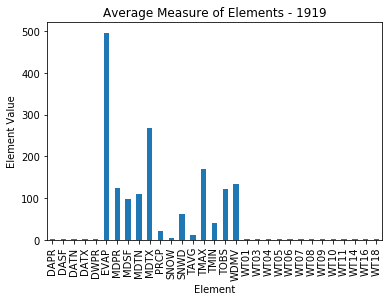

In [28]:
plot = df_1919_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 1919')

The Peak Gust Time(PGTM) was not recorded in 1919. This could be because over the years data collection has become more precise and has extended to greater categories. The wind measurements did not vary between the two years. However, temperature did change immensely. The average temperature in 2019 was 103.570584 tenths of a degree celsius and the average temperature in 1919 was 11.461355. Likewise, when comparing the minimum temperatures, 2019 had a higher minimum temperature than 1919. Overall, this shows some evidence that climate has changed in the past 100 years.

## **Aaron Leonard**
If you don't want a graph, you can simply run an argument, that takes the csv and aggregates it down to a single number.
We use median() and mean() to get the median and mean of TMAX and TMIN in both 1919 and 2019.
The median and mean of TMAX in 2019 is 17.5 and 16.4 respectively:

In [29]:
df_2019[df_2019['Element']=='TMAX']['Element_Value'].median()/10 # Divide by 10 because the max tempertures are measured in tenth of celcius degree.

17.5

In [30]:
df_2019[df_2019['Element']=='TMAX']['Element_Value'].mean()/10

16.368728178213615

In [31]:
df_1919[df_1919['Element']=='TMAX']['Element_Value'].median()/10

18.3

In [32]:
df_1919[df_1919['Element']=='TMAX']['Element_Value'].mean()/10

16.823654077359357

It seems that the overall maximum temperature in 2019 is lower than that in 1919.
The median and mean of TMIN in 2019 is 5.7 and 5.2 respectively:

In [33]:
df_2019[df_2019['Element']=='TMIN']['Element_Value'].median()/10 # Divide by 10 because the max tempertures are measured in tenth of celcius degree.

5.7

In [34]:
df_2019[df_2019['Element']=='TMIN']['Element_Value'].mean()/10

5.189925900894149

The median and mean of TMIN in 1919 is 4.4 and 4.0 respectively:

In [35]:
df_1919[df_1919['Element']=='TMIN']['Element_Value'].median()/10

4.4

In [36]:
df_1919[df_1919['Element']=='TMIN']['Element_Value'].mean()/10

4.044388821263414

It seems that the overall minimmum temperature in 2019 is lower than that in 1919.

## **Olivia Song**

The dataset contains an observation time variable that is set up as yyyy/mm/dd. It would be easier to read if it could be split up. 

## **Datetime Package**
You might have noticed that the "Date" column is in integer type, which will cause some trouble if we want to plot a time series graph. Analyzing datasets with dates and times is often very cumbersome. Months of different lengths, different distributions of weekdays and weekends, leap years, and the dreaded timezones are just a few things you may have to consider depending on your context. For this reason, Python has a data type specifically designed for dates and times called datetime. In this specific case, you may want to convert "Date" colulmn from integer type to datetime type.
We first import the package.


In [37]:
from datetime import datetime, timedelta

Then we write a function that can help us to convert the datetime.

In [38]:
def toDatetime(x):
    x = str(x) # convert the integer type to string.
    date = datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) # cut the string into pieces and convert them to datetime type.
    return date

Since we want to apply the function to all rows of "Date" column, we have to convert the dataset to a pandas datafreme and then use ".apply()" to apply the function.

In [39]:
df_1919['Date'] = df_1919['Date'].apply(toDatetime)

Because of the limitation of the memory space in AWS Sagemaker Notebook, below we will only show the example on 1919 data rather than 2019 data, which is a larger dataset that can occationally cause the kernel crash.
Let's look at the new "Date" column.

In [40]:
df_1919.head()

,ID,Date,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
0,USC00242347,1919-01-01,TMAX,-94,NaN,NaN,6,NaN
1,USC00242347,1919-01-01,TMIN,-183,NaN,NaN,6,NaN
2,USC00242347,1919-01-01,TOBS,-183,NaN,NaN,6,NaN
3,USC00242347,1919-01-01,PRCP,58,NaN,NaN,6,NaN
4,USC00242347,1919-01-01,SNOW,102,NaN,NaN,6,NaN


Now it's in datetime type!

## **Indexing pandas DataFrames with DatetimeIndex**
After you've converted the date column to the datetime format, it is usually a good idea to index your DataFrame by the date, creating the DatetimeIndex. Like the datetime type, the DatetimeIndex is a special index type designed to work with dates and times. By using the .set_index() method with the inplace argument set equal to True, you can remove the date column from your dataset and append it as the index of your DataFrame:

In [41]:
# Set index
df_1919.set_index('Date', inplace=True)

In [42]:
df_1919TMAX= df_1919[df_1919['Element']=='TMAX']
df_1919date=df_1919TMAX.groupby('Date')
df_1919date["Element_Value"].mean()

Date
1919-01-01    15.108004
1919-01-02     1.982838
1919-01-03   -12.692454
1919-01-04    -7.371561
1919-01-05    -1.551394
1919-01-06    22.033986
1919-01-07    38.292650
1919-01-08    52.380656
1919-01-09    48.297451
1919-01-10    56.431831
1919-01-11    56.592754
1919-01-12    56.043205
1919-01-13    65.478946
1919-01-14    63.861656
1919-01-15    62.596721
1919-01-16    70.426507
1919-01-17    79.092249
1919-01-18    91.865757
1919-01-19    90.257198
1919-01-20    87.411427
1919-01-21    88.330233
1919-01-22    88.953800
1919-01-23    88.586743
1919-01-24    84.009254
1919-01-25    78.549196
1919-01-26    83.614059
1919-01-27    82.900435
1919-01-28    82.284434
1919-01-29    82.474470
1919-01-30    79.311991
                ...    
1919-12-02    19.616799
1919-12-03    20.012342
1919-12-04    34.089462
1919-12-05    40.519220
1919-12-06    49.507290
1919-12-07    49.526606
1919-12-08    19.067857
1919-12-09     0.173674
1919-12-10     1.459043
1919-12-11    11.697144
1919-12-12 

## **Time Series Graph**

Setting the DatetimeIndex in your DataFrame unlocks a whole set of useful functionalities. For example, when visualizing your time series data, pandas automatically creates reasonably spaced date labels for the x-axis:

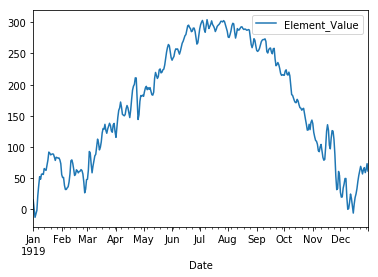

In [43]:
df_1919date_1 = df_1919date["Element_Value"].mean()
df_1919date_2 = pd.DataFrame(df_1919date_1)
df_1919date_2.plot()

From this graph, we can see the trend of the mean of TMAX through 1919 whole year. It reaches the highest point in August and the lowest point in mid January. Because of the memory space limitaiton, it is harder to plot the corresponsing graph in 2019. However, we believe you already learned the basic methods, namely, converting datetime type and indexing based on datetime, which you can apply when you want to plot other time series graphs.

## ***Conclusion***

The research question we want to demonstrate is how climate has changed over 100 years, from 1919 to 2019. We first create unique s3 buckets since the datasets are huge. It is impossible for us to actually read in the dataset directly, so we have to use s3 buckets as a storage tool and copy the datasets we need into the buckets, and then do some processing. After cleaning the dataset and giving column names, we can compare the two plots of 1919 and 2019 with average measure of each element recorded directly and we can see that there is an approximately 10 degrees celsius difference in average temperature, indicating the climate has changed greatly over years.

However, after selecting the specific columns that we need and comparing the maximum and minimum temperature on average, we find out that there is actually a slight decrease of 0.5 degrees Celsius in maximum temperature and a 1 degree Celsius increase in minimum temperature. This does not fit the original assumption of great change in climate, so it raises a question about why the average temperature changes so much while the maximum even decreases a little.

In this case, we would like to take a closer look and see the difference in the distribution of the maximum temperature through the whole year. However, because of the limitation of memory, we can only see the change of average maximum temperature plot for 1919. Yet, we can still conclude that although the average maximum and minimum temperature do not seem to change much, the climate warming is happening since the increase in average temperature indicates an increase in hotter days in a year.

After finishing the notebook, we choose a theme and several extensions to make the webpage more reader friendly. Then, we use the code jupyter convert in the terminal of SageMaker to convert it into an html. Then we download the file and upload to the s3 bucket, setting the permissions to be open to the public.

From our work, people can get an idea of how climate changes in 100 years. They should also realize if they keep improving the technology but not at the same time protect the environment, there will be more hotter days and the minimum temperature will also rise. If they want to do analysis to see how other indexes of climate change, they can also view our project as a demo, as they can learn how to access data from s3 bucket from our work, which is a useful way to process large samples of data.

To improve our work, as people may want to see more directly from the graph of how the temperature changes each month correspondingly over time, we can use a notebook instance with a larger memory so that we can graph the plot of 2019 and compare it to the plot of 1919. Also, our conclusion can be more comprehensive if we can process more datasets and have graphs with larger time series.